In [1]:
# from google.colab import drive
# from shutil import copyfile
# drive.mount('/content/drive', force_remount=True)

In [2]:
# !cp -R "/content/drive/My Drive/Colab Notebooks/tram_sound/data" ./
# !cp "/content/drive/My Drive/Colab Notebooks/tram_sound/"*.pickle ./
# !cp "/content/drive/My Drive/Colab Notebooks/tram_sound/"*.py ./
# !ls ./

In [3]:
# !rm ./*.py
# !cp "/content/drive/My Drive/Colab Notebooks/tram_sound/"*.py ./

In [4]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np

from scipy import signal
from scipy.io import wavfile

from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer

from pickle import Pickler, Unpickler

import os
from tqdm import tqdm

import xgboost as xgb
from xgboost import XGBClassifier

from cust_roc_score import cust_roc_score, multi_class_scorer
import operator

import IPython.display as ipd

from python_speech_features import mfcc, logfbank
from matplotlib import cm

import pandas as pd

import math 
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [5]:
plt.style.use("ggplot")

In [6]:
tram_types = ["1_New", "2_CKD_Long", "3_CKD_Short", "4_Old"]
acc_types = ["accelerating", "braking"]
all_types = acc_types + ["negative"]

root_folder = "."
test_folder = f"{root_folder}/data"
data_folder = f"{root_folder}/data/dataset"

In [7]:
ipd.Audio(f'{data_folder}/accelerating/1_New/tram-2018-11-17-15-12-19_59.20_62.63.mp4.wav')

In [8]:
fs, data = wavfile.read(f'{data_folder}/accelerating/1_New/tram-2018-11-17-15-12-19_59.20_62.63.mp4.wav')
fs0, data0 = wavfile.read(f'{data_folder}/accelerating/1_New/tram-2018-11-17-19-31-02_210.00_213.43.mp4.wav') 
fs2, data2 = wavfile.read(f'{data_folder}/accelerating/2_CKD_Long/tram-2018-11-17-18-25-00_92.17_95.87.mp4.wav')
fs3, data3 = wavfile.read(f'{data_folder}/accelerating/2_CKD_Long/tram-2018-11-18-05-23-51_31.73_35.43.mp4.wav')

In [9]:
fs5, data5 = wavfile.read(f'{data_folder}/braking/1_New/tram-2018-11-19-05-01-06_12.43_17.20.mp4.wav')
fs6, data6 = wavfile.read(f'{data_folder}/braking/2_CKD_Long/tram-2018-11-17-19-22-50_160.53_164.77.mp4.wav')

In [10]:
def plot_mfcc(fs, data):
    mfcc_feat = mfcc(data,fs, nfft=551)
    ig, ax = plt.subplots()
    mfcc_data= np.swapaxes(mfcc_feat, 0 ,1)
    cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
    ax.set_title('MFCC')
    #Showing mfcc_data
    plt.show()
    #Showing mfcc_feat
    plt.plot(mfcc_feat)
    plt.show()

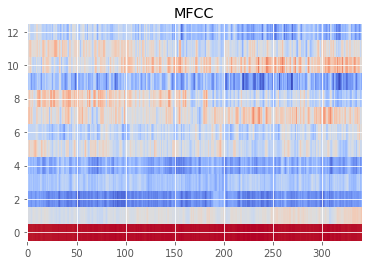

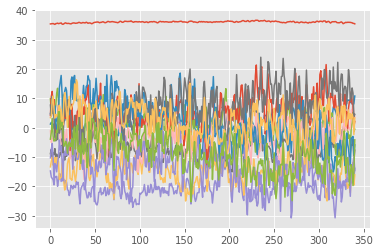

In [11]:
plot_mfcc(fs, data)

In [12]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

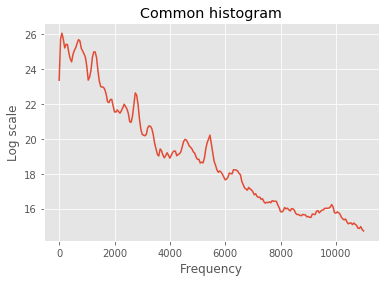

In [13]:
def plot_histogram(data, fs, title, offset = None):
    freq, times, spaces = log_specgram(data, fs)
    if offset != None:
        plt.plot(freq, spaces[:offset, :].mean(axis=0))
        plt.plot(freq, spaces[-offset:, :].mean(axis=0), linestyle='dashed')
    else:
        plt.plot(freq, spaces.mean(axis=0))
    plt.ylabel("Log scale")
    plt.xlabel("Frequency")
    plt.title(title)
    plt.show()

plot_histogram(data, fs, "Common histogram")

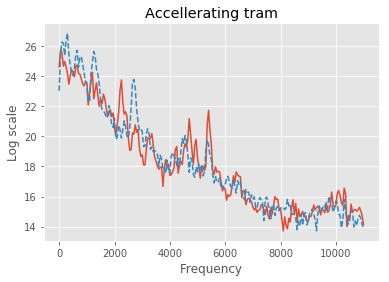

In [14]:
plot_histogram(data0, fs0, "Accellerating tram", 10)

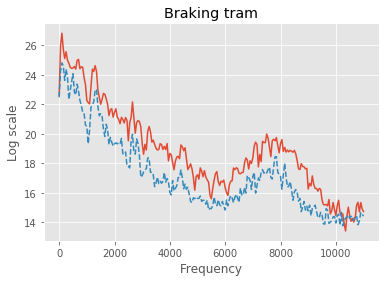

In [15]:
plot_histogram(data5, fs5, "Braking tram", 10)

In [16]:
def split_into_blocks(data, fs, time_window = 3):
    if time_window == None:
        return [data]
    frames_req = int(time_window * fs)
    steps = int(math.ceil(len(data)/frames_req))
    blocks = []
    for i in range(steps):
        blocks.append(data[(i * frames_req):((i+1) * frames_req)])
    return blocks

In [17]:
def create_sound_features(data, fs):
    bins = 10
    emphasized_data = numpy.append(data[0], data[1:] - 0.95 * data[:-1])
    result_feature = deque()
    mfcc_feat = mfcc(emphasized_data,fs, nfft=551)
    for space_bin in np.array_split(mfcc_feat, bins):
        result_feature.extend(space_bin.mean(axis=0))
    log_feat = logfbank(emphasized_data,fs, nfft=551)
    for space_bin in np.array_split(log_feat, bins):
        result_feature.extend(space_bin.mean(axis=0))
    return np.array(result_feature)

def prepare_file(root, file, time_window = None):
    tmp_Y_type = np.argmax([t_type in root for t_type in tram_types])
    tmp_Y_acc = np.argmax([a_type in root for a_type in acc_types])
    fs, data = wavfile.read(f"{root}/{file}")
    blocks = split_into_blocks(data, fs, time_window=time_window)
    tmp_X_datas = []
    for block in blocks:
        sound_features = create_sound_features(block, fs)
        tmp_X_datas.append(sound_features)
    tmp_Y_types = np.ones(len(blocks)) * tmp_Y_type
    tmp_Y_accs = np.ones(len(blocks)) * tmp_Y_acc
    return tmp_X_datas, tmp_Y_types, tmp_Y_accs

In [18]:
data, t_type, accs = prepare_file("c:/_Projects/sounds_tram/data/dataset/accelerating/1_New", "tram-2018-11-17-14-20-54_63.40_66.80.mp4.wav")
print(np.array(data).shape, t_type, accs)

NameError: name 'numpy' is not defined

In [ ]:
data, t_type, accs = prepare_file("c:/_Projects/sounds_tram/data/dataset/braking/4_Old", "tram-2018-11-17-19-47-25_96.57_100.37.mp4.wav")
print(np.array(data).shape, t_type, accs)

In [ ]:
X = deque()
Y_type = deque()
Y_acc = deque()

for root, dir, files in os.walk(data_folder):
    if any([t_type in root for t_type in tram_types]):
        for file in files:
            tmp_X, tmp_Y_type, tmp_Y_acc = prepare_file(root, file)
            X.extend(tmp_X)
            Y_type.extend(tmp_Y_type)
            Y_acc.extend(tmp_Y_acc)
            
X = np.array(X)
Y_type = np.array(Y_type).astype(np.uint8)
Y_acc = np.array(Y_acc).astype(np.uint8)

In [ ]:
def compute_corr(x):
    return [compute_col_corr(x, y) for y in range(x + 1, X.shape[1])]
        
def compute_col_corr(x, y):
    return x, y, np.corrcoef(X[:, x], X[:, y])[0,1]

In [ ]:
with open(f'{root_folder}/data.pickle', 'wb') as f:
    Pickler(f).dump((X, Y_type, Y_acc))

In [ ]:
with open(f'{root_folder}/data.pickle', 'rb') as f:
    X, Y_type, Y_acc = Unpickler(f).load()

In [ ]:
types_hist = np.unique(Y_type, return_counts=True)
plt.bar(types_hist[0], types_hist[1])
plt.xticks(types_hist[0], types_hist[0])
plt.xlabel("Tram type")
plt.ylabel("Occurrence")
plt.title("Tram type occurence")
plt.show()

In [ ]:
acc_hist = np.unique(Y_acc, return_counts=True)
plt.bar(acc_hist[0], acc_hist[1])
plt.xticks(acc_hist[0], acc_hist[0])
plt.xlabel("Acceleration type")
plt.ylabel("Occurrence")
plt.title("Acceleration occurence")
plt.show()

In [ ]:
Y_split = np.hstack(
    (LabelBinarizer().fit_transform(Y_type),
    Y_acc.reshape(-1,1))
)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(X, Y_split):
    X_train, X_test = X[train_index], X[test_index]
    Y_type_train, Y_type_test = Y_type[train_index], Y_type[test_index]
    Y_acc_train, Y_acc_test = Y_acc[train_index], Y_acc[test_index]
    
print(X_train.shape, X_test.shape)
print(Y_type_train.shape, Y_type_test.shape)
print(Y_acc_train.shape, Y_acc_test.shape)

In [ ]:
with open(f'{root_folder}/data_split.pickle', 'wb') as f:
    Pickler(f).dump((X_train, X_test, Y_type_train, Y_type_test, Y_acc_train, Y_acc_test))

In [ ]:
with open(f'{root_folder}/data_split.pickle', 'rb') as f:
    X_train, X_test, Y_type_train, Y_type_test, Y_acc_train, Y_acc_test = Unpickler(f).load()
    
print(X_train.shape, X_test.shape)
print(Y_type_train.shape, Y_type_test.shape)
print(Y_acc_train.shape, Y_acc_test.shape)

In [ ]:
# acc_params = {
#     "learning_rate": [0.01, 0.05, 0.1, 0.3],
#     "n_estimators": [50, 100, 150, 200, 250, 300],
#     "max_depth": [3, 5, 8, 10],
#     "min_child_weight": [1, 3, 5],
#     "gama": [0, 0.1, 0.5]
# }

acc_params = {'gama': [0],
 'learning_rate': [0.3],
 'max_depth': [3],
 'min_child_weight': [1],
 'n_estimators': [300]
}

acc_xgb = XGBClassifier(objective='binary:logistic', eval_metric = "auc")

In [ ]:
acc_est = GridSearchCV(acc_xgb, acc_params, 
                        scoring="roc_auc", 
                        cv=5,
                        verbose=1,
                        n_jobs = -1,
                        return_train_score=True
                        )
acc_fit = acc_est.fit(X_train, Y_acc_train)

In [ ]:
roc_auc_score(Y_acc_test, acc_est.predict(X_test))

# 0.9839514066496164

In [ ]:
with open(f'{root_folder}/acc_est.pickle', 'wb') as f:
    Pickler(f).dump((acc_fit, acc_est))

In [ ]:
with open(f'{root_folder}/acc_est.pickle', 'rb') as f:
    acc_fit, acc_est = Unpickler(f).load()

In [ ]:
acc_fit.best_params_

In [ ]:
# type_params = {
#     "learning_rate": [0.05, 0.1, 0.3],
#     "n_estimators": [100, 200, 250, 300, 350],
#     "max_depth": [3, 5, 8],
#     "min_child_weight": [1, 3, 5],
#     "gama": [0, 0.1, 0.5]
# }

type_params = {'gama': [0],
 'learning_rate': [0.3],
 'max_depth': [3],
 'min_child_weight': [1],
 'n_estimators': [300]
}

type_xgb = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(Y_type)), 
                         eval_metric = "auc")

In [ ]:
scorer = cust_roc_score()
type_est = GridSearchCV(type_xgb, type_params, 
                        scoring=scorer, 
                        cv=5,
                        verbose=1,
                        n_jobs = -1,
                        return_train_score=True
                         )
type_fit = type_est.fit(X_train, Y_type_train)

In [ ]:
multi_class_scorer(Y_type_test, type_fit.predict(X_test))

# 0.9792852180370323

In [ ]:
with open(f'{root_folder}/type_est.pickle', 'wb') as f:
    Pickler(f).dump((type_fit, type_est))

In [ ]:
with open(f'{root_folder}/type_est.pickle', 'rb') as f:
    type_fi, type_est = Unpickler(f).load()

In [ ]:
type_fit.best_params_

In [ ]:
lb = LabelBinarizer()
lb.fit(Y_type)
       
final_Y_true = np.hstack(
    (lb.transform(Y_type_test), Y_acc_test.reshape(-1,1))
)
Y_test_type = type_est.predict(X_test)
Y_acc_type = acc_est.predict(X_test)
final_Y_pred = np.hstack(
    (lb.transform(Y_test_type), acc_est.predict(X_test).reshape(-1,1))
)
roc_auc_score(final_Y_true, final_Y_pred)

# 0.9802184557595492

In [ ]:
def make_single_number(Y_type_input, Y_acc_input):
    return Y_type_input + (10 * Y_acc_input)

cm_true_test = make_single_number(Y_type_test, Y_acc_test)
cm_pred_test = make_single_number(Y_test_type, Y_acc_type)

confusion_matrix(cm_true_test, cm_pred_test)

In [ ]:
negative_file = f'{data_folder}/negative/checked/tram-2018-11-19-01-54-22_232_242.mp4.wav'
neg_fs, neg_data = wavfile.read(negative_file)
ipd.Audio(negative_file)

In [ ]:
plot_histogram(neg_data, neg_fs, "Silence sound")

In [ ]:
plot_histogram(neg_data, neg_fs, "Silence sound gaps", 10)

In [ ]:
X_neg = deque()
Y_neg = deque()

for root, dir, files in os.walk(f"{data_folder}"):
    if any([a_type in root for a_type in all_types]):
        for file in files:
            is_mute_file = not any([a_type in root for a_type in acc_types])
            if is_mute_file:
                tmp_X, _, _ = prepare_file(root, file, time_window=3)
            else:
                tmp_X, _, _ = prepare_file(root, file)
            X_neg.extend(tmp_X)
            Y_neg.extend(np.ones(len(tmp_X), dtype=np.uint8) * int(is_mute_file))
            
X_neg = np.array(X_neg)
Y_neg = np.array(Y_neg)

In [ ]:
with open(f'{root_folder}/neg_data.pickle', 'wb') as f:
    Pickler(f).dump((X_neg, Y_neg))

In [ ]:
with open(f'{root_folder}/neg_data.pickle', 'rb') as f:
    X_neg, Y_neg = Unpickler(f).load()

In [ ]:
sss_neg = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss_neg.split(X_neg, Y_neg):
    X_neg_train, X_neg_test = X_neg[train_index], X_neg[test_index]
    Y_neg_train, Y_neg_test = Y_neg[train_index], Y_neg[test_index]
    
print(X_neg_train.shape, X_neg_test.shape)
print(Y_neg_train.shape, Y_neg_test.shape)

In [ ]:
with open(f'{root_folder}/neg_train_data.pickle', 'wb') as f:
    Pickler(f).dump((X_neg_train, X_neg_test, Y_neg_train, Y_neg_test))

In [ ]:
with open(f'{root_folder}/neg_train_data.pickle', 'rb') as f:
    X_neg_train, X_neg_test, Y_neg_train, Y_neg_test = Unpickler(f).load()

In [ ]:
neg_hist = np.unique(Y_neg, return_counts=True)
plt.bar(neg_hist[0], neg_hist[1])
plt.xticks(neg_hist[0], neg_hist[0])
plt.xlabel("Negative type")
plt.ylabel("Occurrence")
plt.title("Negative occurence")
plt.show()

In [ ]:
# neg_params = {
#     "learning_rate": [0.05, 0.1, 0.3],
#     "n_estimators": [100, 200, 250, 300, 350],
#     "max_depth": [3, 5, 8],
#     "min_child_weight": [1, 3, 5],
#     "gama": [0, 0.1, 0.5]
# }

neg_params = {'gama': [0],
 'learning_rate': [0.3],
 'max_depth': [3],
 'min_child_weight': [1],
 'n_estimators': [300]
}

neg_xgb = XGBClassifier(objective='binary:logistic', eval_metric = "auc")

In [ ]:
neg_est = GridSearchCV(neg_xgb, neg_params, 
                        scoring="roc_auc", 
                        cv=5,
                        verbose=1,
                        n_jobs = -1,
                        return_train_score=True
                        )
neg_fit = neg_est.fit(X_neg_train, Y_neg_train)

In [ ]:
roc_auc_score(Y_neg_test, neg_est.predict(X_neg_test))

# 0.9881046620112521

In [ ]:
neg_fit.best_params_

In [ ]:
with open(f'{root_folder}/neg_est.pickle', 'wb') as f:
    Pickler(f).dump((neg_fit, neg_est))

In [ ]:
with open(f'{root_folder}/neg_est.pickle', 'rb') as f:
    neg_fit, neg_est = Unpickler(f).load()

In [ ]:
# type_params = {
#     "learning_rate": [0.05, 0.1, 0.3],
#     "n_estimators": [100, 200, 250, 300, 350],
#     "max_depth": [3, 5, 8],
#     "min_child_weight": [1, 3, 5],
#     "gama": [0, 0.1, 0.5]
# }

combined_params = {'gama': [0],
 'learning_rate': [0.3],
 'max_depth': [3],
 'min_child_weight': [1],
 'n_estimators': [300]
}

combined_xgb = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(make_single_number(Y_type, Y_acc))), 
                         eval_metric = "auc")

In [ ]:
combined_est = GridSearchCV(combined_xgb, combined_params, 
                        scoring=scorer, 
                        cv=5,
                        verbose=1,
                        n_jobs = -1,
                        return_train_score=True
                        )
combined_fit = combined_est.fit(X_train, make_single_number(Y_type_train, Y_acc_train))

In [ ]:
combined_fit.best_params_

In [ ]:
with open(f'{root_folder}/comb_est.pickle', 'wb') as f:
    Pickler(f).dump((combined_fit, combined_est))

In [ ]:
with open(f'{root_folder}/comb_est.pickle', 'rb') as f:
    combined_fit, combined_est = Unpickler(f).load()

In [ ]:
comb_label_binarizer = LabelBinarizer()
exp_comb_results = make_single_number(Y_type_test, Y_acc_test)
pred_comb_results = combined_est.predict(X_test)
comb_label_binarizer.fit(
    np.concatenate((exp_comb_results,pred_comb_results))
)
roc_auc_score(comb_label_binarizer.transform(exp_comb_results), comb_label_binarizer.transform(pred_comb_results))

#0.9606596942356406

In [ ]:
combined_meta_train = np.hstack((
    type_est.predict_proba(X_train),
    acc_est.predict_proba(X_train),
    combined_est.predict_proba(X_train)))

combined_meta_test = np.hstack((
    type_est.predict_proba(X_test),
    acc_est.predict_proba(X_test),
    combined_est.predict_proba(X_test)))

In [ ]:
linear_params = {
    "penalty": ["l2"],
    "C": [1.0, 0.8, 0.6, 0.4, 0.2],
    "solver": ["saga", "newton-cg"]
}

# linear_params = {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}

linear = LogisticRegression(multi_class="multinomial")
linear_est = GridSearchCV(linear, linear_params, 
                        scoring=scorer, 
                        cv=5,
                        verbose=1,
                        n_jobs = -1,
                        return_train_score=True
                        )

linear_fit = linear_est.fit(combined_meta_train, make_single_number(Y_type_train, Y_acc_train))

In [ ]:
linear_fit.best_params_

In [ ]:
with open(f'{root_folder}/lin_est.pickle', 'wb') as f:
    Pickler(f).dump((linear_fit, linear_est))

In [ ]:
with open(f'{root_folder}/lin_est.pickle', 'rb') as f:
    linear_fit, linear_est = Unpickler(f).load()

In [ ]:
np.argmax(linear_est.predict_proba(combined_meta_test)[0])

In [ ]:
linear_predictions = linear_est.predict(combined_meta_test)

roc_auc_score(comb_label_binarizer.transform(exp_comb_results), comb_label_binarizer.transform(linear_predictions))

# 0.9637915554005194

In [ ]:
class TimeBlock:
    def __init__(self, start, tram_acc_ind, delta = 0.6):
        self.delta = delta
        self.start = start
        self.end = start
        self.tram_acc_inds = {}
        self.add(tram_acc_ind)
    
    def add(self, tram_acc_ind):
        self.tram_acc_inds[tram_acc_ind] = self.tram_acc_inds.get(tram_acc_ind, 0) + 1
        
    def get_tram_acc_type(self):
        return max(self.tram_acc_inds.items(), key=operator.itemgetter(1))[0]
    
    def is_within_block(self, time):
        return ((self.start - self.delta) <= time) and (time <= (self.end + self.delta))
    
    def add_new_time(self, time):
        if self.is_within_block(time):
            self.start = min(self.start, time)
            self.end = max(self.end, time)

    def __repr__(self):
        tab = "\n\t"
        return f"TimeBlock[{tab}start:{self.start},{tab}end:{self.end},{tab}comb:{self.tram_acc_inds}\n]"

In [ ]:
def create_test_blocks(input_file, window_len = 3, time_step = 0.2):
    fs, data = wavfile.read(input_file)
    test_blocks = deque()
    step_size = window_len * fs
    for start_time in range(0, len(data), int(time_step * fs)):
        tmp_data = data[start_time:start_time + step_size]
        sound_features = create_sound_features(tmp_data, fs)
        test_blocks.append(sound_features)
    return np.array(test_blocks)  

def get_sound_blocks(input_file, delta = 0.6, min_dur = 1.5):
    test_sound = create_test_blocks(input_file)
    predict_sound = neg_est.predict(test_sound)
    predict_type = type_est.predict_proba(test_sound)
    predict_acceleration = acc_est.predict_proba(test_sound)
    predict_type_acceleration = combined_est.predict_proba(test_sound)
    combined_meta_train = np.hstack((
        predict_type,
        predict_acceleration,
        predict_type_acceleration))
    final_predictions = linear_est.predict(combined_meta_train)
    sound_time = deque()
    last_block = None
    for index, (quiet_ind, final_prediction) in enumerate(zip(predict_sound, final_predictions)):
        if quiet_ind == 0:
            seconds = index * 0.2
            if (last_block == None or not last_block.is_within_block(seconds)):
                if last_block != None:
                    sound_time.append(last_block)
                last_block = TimeBlock(seconds, final_prediction, delta=delta)
            else:
                last_block.add_new_time(seconds)
                last_block.add(final_prediction)
    sound_time.append(last_block)
    return filter_blocks(sound_time, min_dur)

def filter_blocks(sound_time_block, min_dur = 1.5):
    return [block for block in sound_time_block if (block.end - block.start) >= min_dur]

In [ ]:
def decode_sound_block(block):
    name, decoded = decode_tram(block.get_tram_acc_type())
    return block.start, name, decoded

def decode_tram(index):
    acc_idx = index // 10
    tram_type_idx = index % 10
    ret_var = np.zeros(len(tram_types) * len(acc_types), dtype=np.uint8)
    ret_var[acc_idx * len(tram_types) + tram_type_idx] = 1
    return f"{acc_types[acc_idx]}_{tram_types[tram_type_idx]}", ret_var

def create_output_line(time, decoded):
    joined_dec = ",".join(str(v) for v in decoded)
    return f"{time:.1f},{joined_dec}"

def create_predict_file(input_path):
    sound_blocks = get_sound_blocks(input_path, delta = 1, min_dur = 1.5)
    dec_list = [decode_sound_block(block) for block in sound_blocks]
    lines = [create_output_line(time, decoded) for time, _, decoded in dec_list]
    nl = "\n"
    with open(f"{input_path}.csv", "wt") as f:
        f.write(f"seconds_offset,accelerating_1_New,accelerating_2_CKD_Long,accelerating_3_CKD_Short,accelerating_4_Old,braking_1_New,braking_2_CKD_Long,braking_3_CKD_Short,braking_4_Old{nl}")
        for line in lines:
            f.write(f"{line}{nl}")
    

In [ ]:
for root, dir, files in os.walk(f'{test_folder}/test_files/'):
    for file in tqdm(files):
        if file.endswith(".wav"):
            create_predict_file(f"{root}{file}")

In [ ]:
get_sound_blocks("c:/_Projects/sounds_tram/data/test_files/tram-2018-11-30-15-30-17.wav", delta = 1, min_dur = 1.5)

In [ ]:
neg_est.predict_proba(X_train)[0]